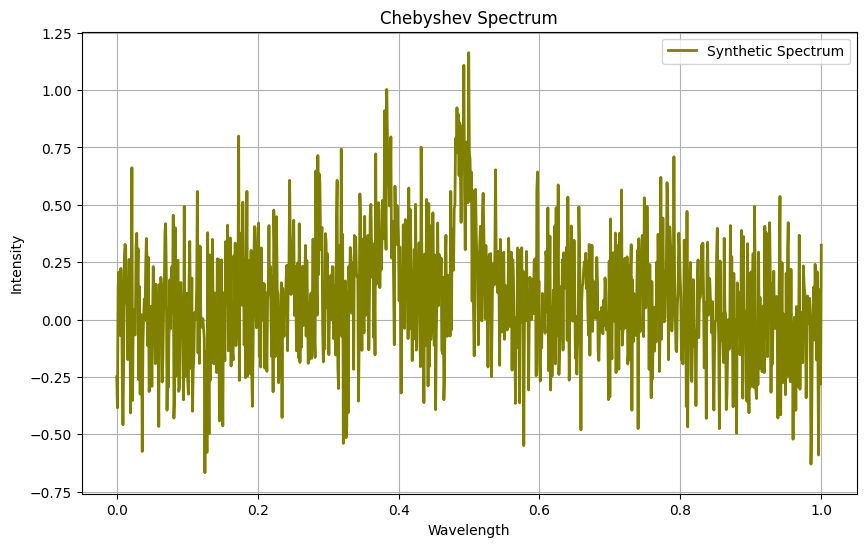

In [2]:
# 4. BASELINE VARIATION
# Baseline variation (iteration) & Polynomial order (random)
# Chebyshev polynomial baseline
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(0, 1, self.pixels)
        self.generate_spectrum()

    # Generate baseline using a polynomial
    def generate_spectrum(self):
        poly_order = np.random.randint(self.poly_order_range[0], self.poly_order_range[1] + 1)
        baseline_coefficients = np.random.rand(poly_order + 1)
        self.baseline = np.polyval(baseline_coefficients, self.wavelengths)

        # Generate Lorentzian peaks
        self.peaks = np.zeros_like(self.wavelengths)
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        for _ in range(num_peaks):
            peak_amplitude = np.random.uniform(0, 1)
            peak_position = np.random.uniform(0.2, 0.8)
            peak_width = 1 / (self.pixels * 0.1)
            self.peaks += peak_amplitude * (peak_width ** 2) / ((self.wavelengths - peak_position) ** 2 + peak_width ** 2)

    # Generate Gaussian noise
    def add_gaussian_noise(self, noise_amplitude_range=(0.1, 0.5)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        noise *= noise_amplitudes

        # Add noise to baseline & peaks
        noisy_baseline = self.baseline + noise
        noisy_peaks = self.peaks + noise

        return noisy_baseline, noisy_peaks

    # Generate Baseline variation
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(x))
        return chebyshev_vals

# Create an instance of SyntheticRamanSpectrum class
synthetic_spectrum = SyntheticRamanSpectrum(
    pixels=1024,
    poly_order_range=(2, 4),
    num_peaks_range=(2, 5),
    snr_range=10,
    cosmic_ray_prob=0.1,
    num_spectra=1
)

# Get the synthetic spectrum and its parameters
wavelengths = synthetic_spectrum.wavelengths

# Add Gaussian noise to synthetic spectrum
noisy_baseline, noisy_peaks = synthetic_spectrum.add_gaussian_noise()

# Specify range for randomly selecting order of Chebyshev polynomial
min_order = 2
max_order = 6

# Number of iterations (baseline segments)
num_iterations = 5

for _ in range(num_iterations):
    # Randomly select polynomial order (for iteration)
    order = np.random.randint(min_order, max_order)

    # Initial guess for Chebyshev polynomial coefficients (randomly initialized)
    initial_guess = [np.random.uniform(-1, 1) for _ in range(order)]

    # Fit Chebyshev polynomial to noisy data (for iteration)
    popt, _ = curve_fit(synthetic_spectrum.chebyshev_polynomial, wavelengths, noisy_peaks, p0=initial_guess)

    # Generate baseline using fitted coefficients
    baseline = synthetic_spectrum.chebyshev_polynomial(wavelengths, *popt)

    # Add Chebyshev to noise, baseline & peaks
    chebyshev_baseline = synthetic_spectrum.baseline + baseline
    chebyshev_peaks = synthetic_spectrum.peaks + baseline
    chebyshev_noise = noisy_peaks + baseline

# Plot Chebyshev spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, chebyshev_noise, color='olive', label='Synthetic Spectrum', linewidth=2)
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Chebyshev Spectrum')
plt.legend()
plt.grid(True)
plt.show()